In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Load the data from Yahoo Finance (for a stock symbol, e.g., 'AAPL' for Apple)
stock_symbol = 'AAPL'  # Change this to your stock symbol or use your dataset
data = yf.download(stock_symbol, start='2010-01-01', end='2020-04-01')

# Display the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2010-01-04 00:00:00+00:00  6.447412  7.643214  7.660714  7.585000  7.622500   
2010-01-05 00:00:00+00:00  6.458560  7.656429  7.699643  7.616071  7.664286   
2010-01-06 00:00:00+00:00  6.355827  7.534643  7.686786  7.526786  7.656429   
2010-01-07 00:00:00+00:00  6.344076  7.520714  7.571429  7.466071  7.562500   
2010-01-08 00:00:00+00:00  6.386255  7.570714  7.571429  7.466429  7.510714   

Price                         Volume  
Ticker                          AAPL  
Date                                  
2010-01-04 00:00:00+00:00  493729600  
2010-01-05 00:00:00+00:00  601904800  
2010-01-06 00:00:00+00:00  552160000  
2010-01-07 00:00:00+00:00  477131200  
2010-01-08 00:00:00+00:00  447610800  


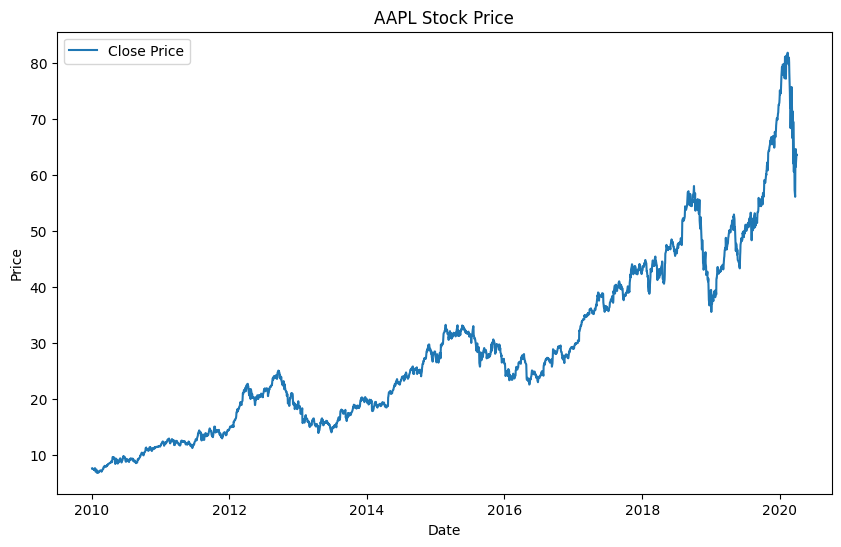

In [3]:
# Visualize the Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{stock_symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
# --- EDA (Exploratory Data Analysis) ---
import seaborn as sns
import matplotlib.pyplot as plt

# Display basic information about the dataset
print(data.info())

# Display the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2577 entries, 2010-01-05 00:00:00+00:00 to 2020-03-31 00:00:00+00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  2577 non-null   float64
 1   (Close, AAPL)      2577 non-null   float64
 2   (High, AAPL)       2577 non-null   float64
 3   (Low, AAPL)        2577 non-null   float64
 4   (Open, AAPL)       2577 non-null   float64
 5   (Volume, AAPL)     2577 non-null   int64  
 6   (Lag_1, )          2577 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 161.1 KB
None
Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2010-01-05 00:00:00+00:00  6.458560  7.656429  7.699643  7.616071  7.664286   
2010-01-06 00:00:00+00:00  6.355827  7.53

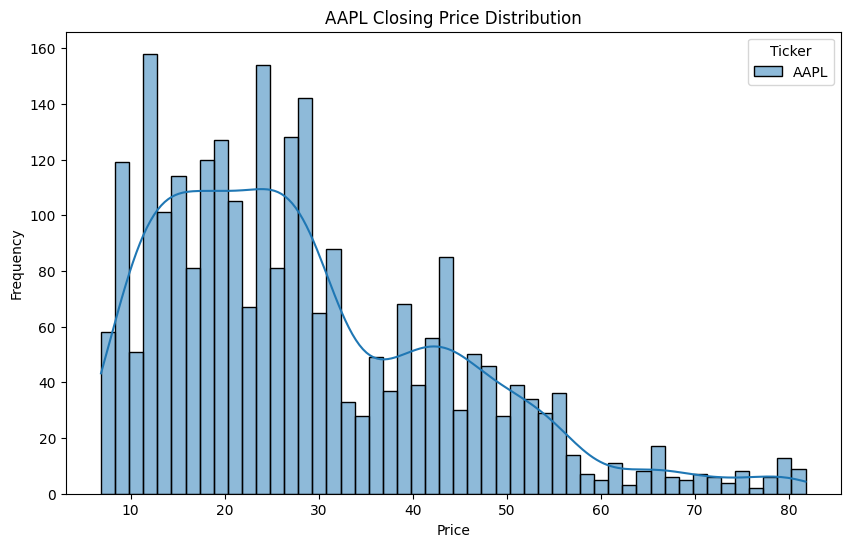

In [9]:

# Plot the distribution of the stock's closing price
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], bins=50, kde=True)
plt.title(f'{stock_symbol} Closing Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


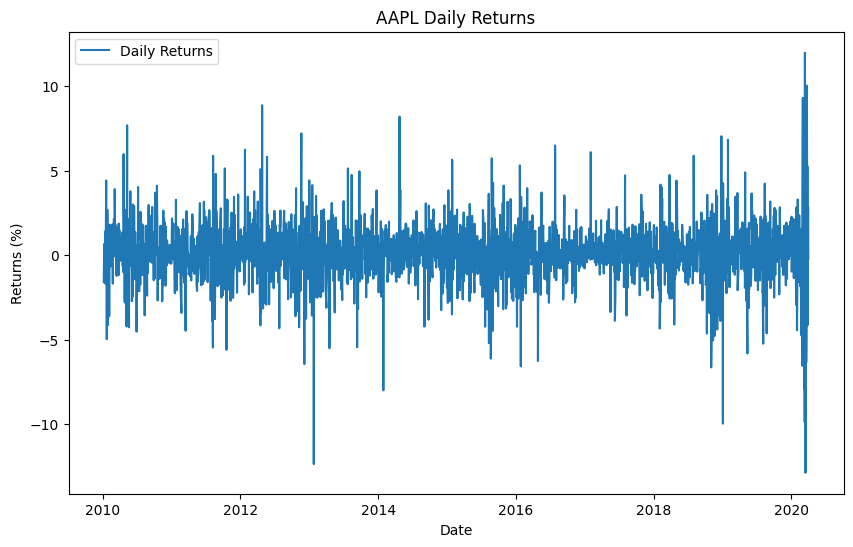

In [10]:

# Plot daily returns (percentage change)
data['Returns'] = data['Close'].pct_change() * 100  # Percentage change in closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Returns'], label='Daily Returns')
plt.title(f'{stock_symbol} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()
plt.show()


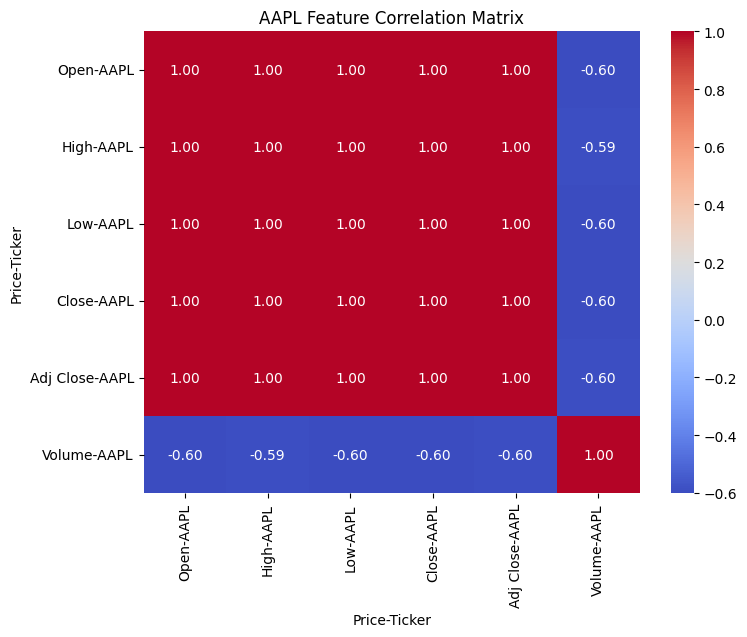

In [11]:

# Visualize the correlation matrix of numerical features
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'{stock_symbol} Feature Correlation Matrix')
plt.show()


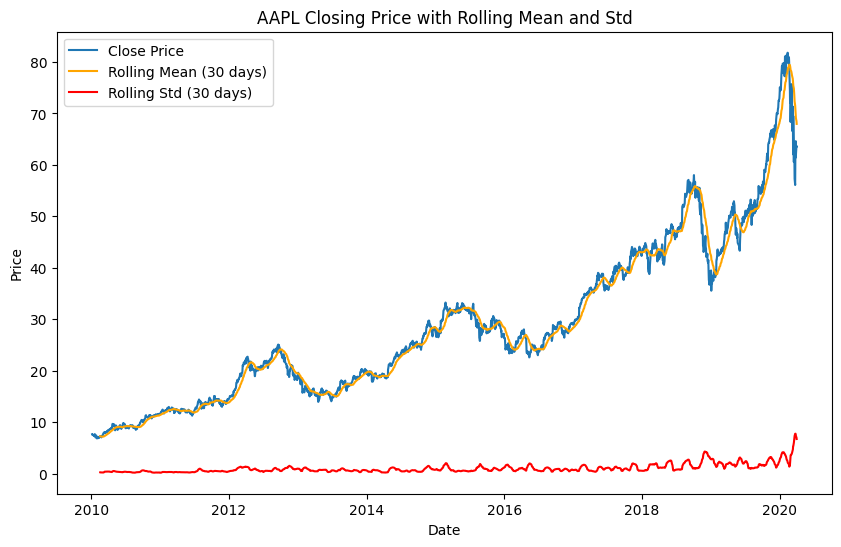

In [12]:

# Check for seasonality by plotting rolling mean and rolling std of the closing price
rolling_mean = data['Close'].rolling(window=30).mean()
rolling_std = data['Close'].rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='orange')
plt.plot(rolling_std, label='Rolling Std (30 days)', color='red')
plt.title(f'{stock_symbol} Closing Price with Rolling Mean and Std')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [17]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create training and testing datasets
train_size = int(len(scaled_data) * 0.80)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences efficiently
def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_sequences(train_data, look_back)
X_test, Y_test = create_sequences(test_data, look_back)

# Reshape the data for LSTM input in one step
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the bi-LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(1, look_back))))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0140 - val_loss: 0.0013
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 1.2626e-04 - val_loss: 0.0012
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 1.0663e-04 - val_loss: 0.0013
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 1.0216e-04 - val_loss: 0.0011
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 9.8534e-05 - val_loss: 9.7369e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 1.0301e-04 - val_loss: 9.5949e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 9.8543e-05 - val_loss: 8.7713e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 9.5604e-05 - val_loss: 8.2516e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 9.2093e-05 - val_loss: 7.5755e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 9.8399e-05 - val_loss: 7.3657e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 8.6270e-05 - val_loss: 7.7795e-04
Epo

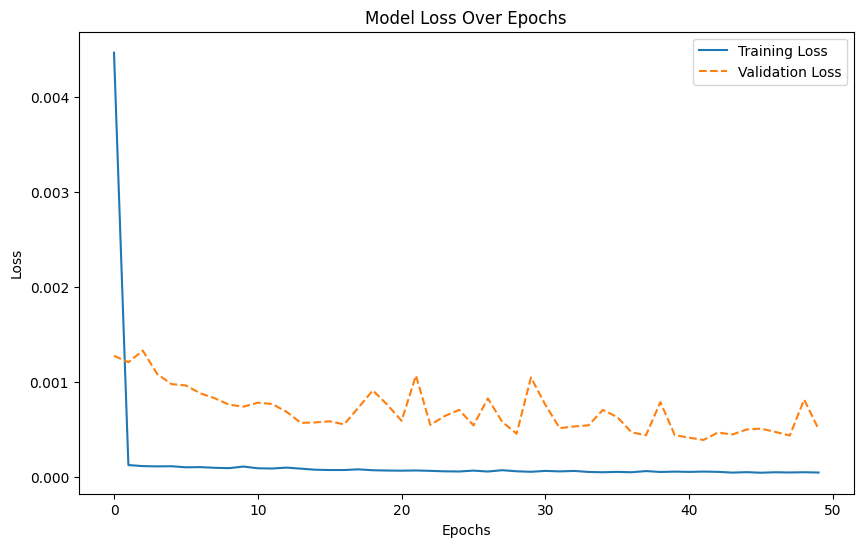

In [18]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert the predictions and true values back to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate performance metrics for training data
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
train_mae = mean_absolute_error(Y_train, train_predict)
train_r2 = r2_score(Y_train, train_predict)

# Calculate performance metrics for testing data
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_mae = mean_absolute_error(Y_test, test_predict)
test_r2 = r2_score(Y_test, test_predict)

# Print the performance metrics
print("Training Performance Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R² Score: {train_r2:.4f}")

print("\nTesting Performance Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R² Score: {test_r2:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Training Performance Metrics:
RMSE: 0.4537
MAE: 0.3324
R² Score: 0.9976

Testing Performance Metrics:
RMSE: 1.6747
MAE: 1.0745
R² Score: 0.9758


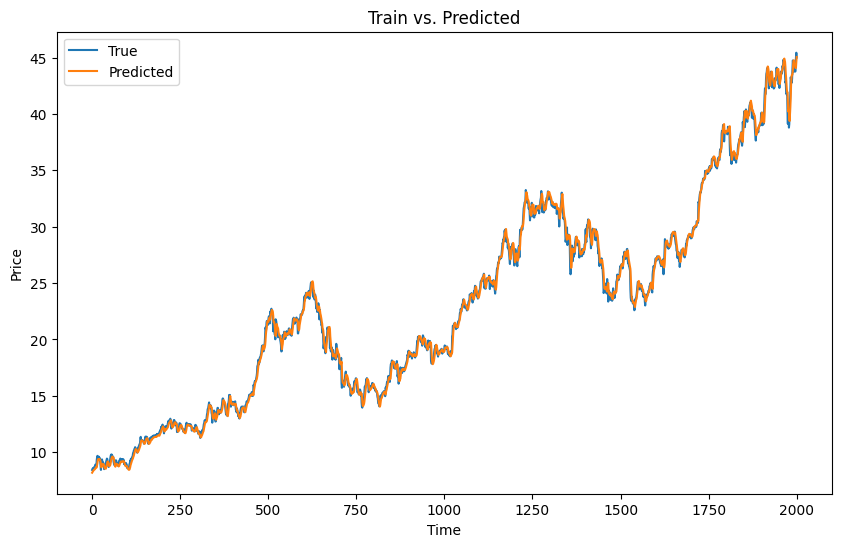

In [20]:
# Plot the train vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(Y_train, label='True')
plt.plot(train_predict, label='Predicted')
plt.title('Train vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

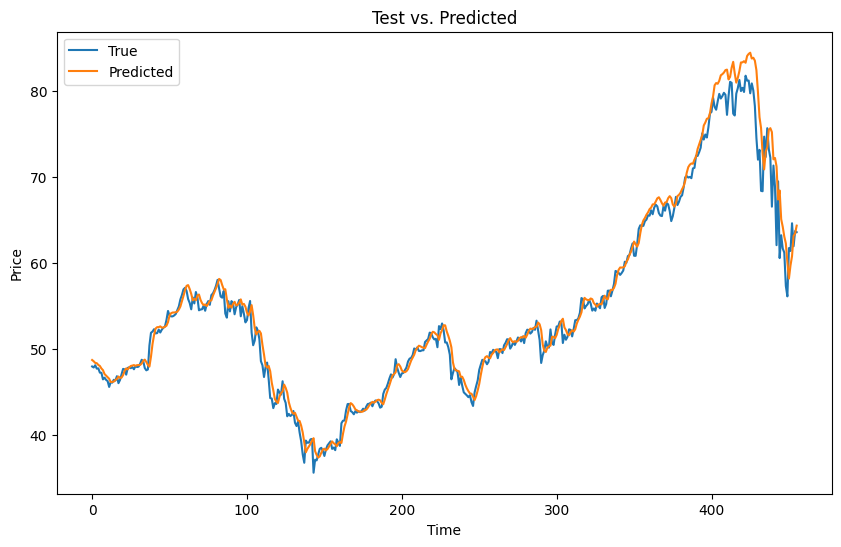

In [21]:
# Plot the test vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='True')
plt.plot(test_predict, label='Predicted')
plt.title('Test vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
